# Assignment 6 - Linear Regression
## Raja Jain | 2022-03-05

In [1]:
import string
from pprint import pprint as pp
import docx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sweetviz as sv
import statsmodels.api as sm
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
from scipy.stats import norm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, Ridge
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)


def getText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return "\n".join(fullText)


In [2]:
text = getText("Assignment 6 - Regression Analysis.docx")
print(text)


COMP 4448: Data Science Tools II						          Assignment 6
Directions: Do this assignment in Jupyter Notebook and provide screenshots of code and output in this word document wherever required. You will upload this word document containing screenshots of code and answers as well as your Jupyter Notebook to Canvas. All assignments will be submitted and graded through canvas and grades will be transferred to the 2U platform. 
Goal: The goal of this assignment is to give you the opportunity to implement the Gradient Algorithm from scratch as well as using tools built into sklearn. You will also run regression analysis, evaluate, test assumptions and provide interpretations using your own data.
Packages: Core packages you may need for this assignment include numpy, pandas, sklearn, matplotlib.pyplot and/or seaborn. 
Question 1
Use the entire health data provided on canvas for this question. Here are the first few rows of the data. 

The variables are described as follows:
age  =  Age in 

In [3]:
# Question 1
# Use the entire health data provided on canvas for this question.

# The variables are described as follows:
# age  =  Age in years divided by 100.
# income = Annual income in tens of thousands of dollars.
# illness = Number of illnesses in past 2 weeks.
# reduced = Number of days of reduced activity in past 2 weeks due to illness or injury.
# health = General health questionnaire score using Goldberg's method. Note that higher health scores indicate worse health condition.
# Use the age, income, illness and reduced variables as input variables and use the health variable as an output variable. You will find the parameters or coefficients (intercept and slopes) of a regression equation that models the relationship between the input and output variables. First use the StandardScaler() in sklearn to standardize the input data before you run your algorithm or fit your model.

health_data = pd.read_csv("Health_Data.csv")
health_data_col = health_data.columns
health_data = StandardScaler().fit_transform(health_data)
health_data = pd.DataFrame(health_data, columns=health_data_col)
health_data


,age,income,illness,reduced,health
0,-1.056765,-0.089896,-0.312123,1.086862,-0.102414
1,-1.056765,-0.360993,-0.312123,0.394185,-0.102414
2,-1.056765,0.858945,1.132944,-0.298492,-0.573210
3,-1.056765,-1.174285,-0.312123,-0.298492,-0.573210
4,-1.056765,-0.360993,0.410410,1.433200,-0.102414
...,...,...,...,...,...
5185,-0.910253,-0.089896,-1.034657,-0.298492,-0.573210
5186,-0.666067,1.943335,-1.034657,-0.298492,-0.102414
5187,-0.177696,-0.903188,-0.312123,-0.298492,-0.102414
5188,0.554862,0.181202,-1.034657,-0.298492,-0.573210


In [4]:
beta_array = [0 for _ in health_data_col]

# Initialize all the b's up to bk, where k = number of features
a = 0.01
# iterations = 10000
iterations = 10000

x = health_data.iloc[:, :-1].values.transpose()
y = health_data.iloc[:, -1].values

for i in range(iterations):
    predicted_y = beta_array[0] + np.dot(beta_array[1:], x)
    errors = y - predicted_y
    beta_array[0] = beta_array[0] + a * (1 / len(errors)) * np.sum(errors)
    for j in range(1, len(beta_array)):
        beta_array[j] = beta_array[j] + a * (1 / len(errors)) * np.sum(errors * x[j - 1])
print(beta_array)


[2.7791941302375174e-17, -0.08132296210707216, -0.0496174683283661, 0.322452658653267, 0.21522187186261957]


In [5]:
# Now, use a vectorized or matrix implementation instead of having a line of code for each x or b. That mean, you can a create a vector of b’s and a feature matrix, X where you have an additional column for x0 whose values are 1’s. x0 corresponds to b0. You can still implement it as described in the code above.
mtx = x.copy()
mtx = np.insert(mtx, 0, 1, axis=0)
beta_mtx = np.array([0 for _ in range(len(mtx))])

beta_zero = []
for i in range(iterations):
    y_pred = np.matmul(beta_mtx, mtx)
    errors = y - y_pred
    new_betas = np.sum(errors.T * mtx, axis=1) * (1 / len(errors)) * a
    beta_mtx = np.array([a + b for a, b in zip(new_betas, beta_mtx)])
    beta_zero.append(beta_mtx[0])
print(beta_mtx)


[ 0.         -0.08132296 -0.04961747  0.32245266  0.21522187]


In [6]:
# Use the scikit-learn package to implement the stochastic gradient descent to find the parameters of the regression equation.
sgdr_model = SGDRegressor(max_iter=iterations, tol=1e-7)
sgdr_model.fit(x.transpose(), y)
print("Intercept:", sgdr_model.intercept_)
print("Coefficients:", sgdr_model.coef_)


Intercept: [-0.00547036]
Coefficients: [-0.0678248  -0.06374904  0.33068549  0.20987145]


In [7]:
# Question 2
# You will implement a multiple regression from a statistical perspective to explore the relationship between the input variables and the output variable. You will use the health data again.

# Use the statsmodels package () to implement a multiple linear regression using the entire health data to get a more detailed regression summary.
# Below is some pseudo code for implementation, see the documentation for details.
# Fit and summarize OLS model
model = sm.OLS(y, x.transpose())
res = model.fit()
print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.179
Model:                            OLS   Adj. R-squared (uncentered):              0.179
Method:                 Least Squares   F-statistic:                              283.0
Date:                Sun, 06 Mar 2022   Prob (F-statistic):                   2.13e-220
Time:                        23:02:11   Log-Likelihood:                         -6851.9
No. Observations:                5190   AIC:                                  1.371e+04
Df Residuals:                    5186   BIC:                                  1.374e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

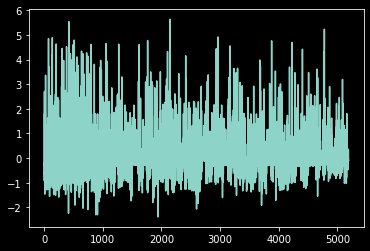

In [8]:
# Extract the residuals of the model and test the assumptions normality and homogeneity of variance for the regression model. Are the assumptions met? Use reg.resid syntax to extract the residuals.
residuals = res.resid
plt.plot(residuals)


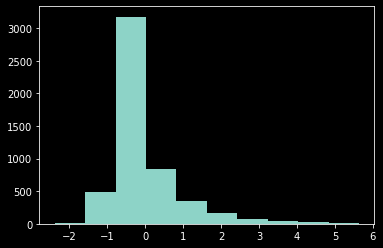

In [9]:
# To further verify the normality assumption, create a histogram for the residuals. Does the histogram look like a normal distribution?
plt.hist(residuals)
plt.show()


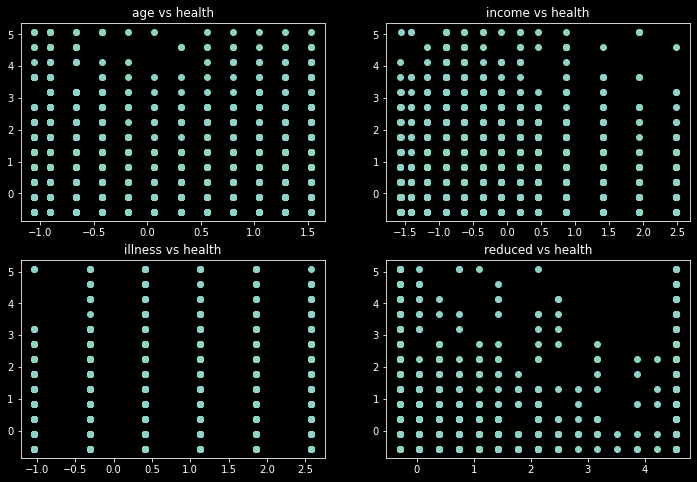

In [10]:
# Test the linearity assumption by creating separate scatter plots for each input variable versus output variable.
# According to your plots, are the linearity assumptions met?
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(health_data.columns[:-1]):
    ax.ravel()[i].scatter(health_data[col], health_data["health"])
    ax.ravel()[i].set_title(f"{col} vs health")
plt.show()


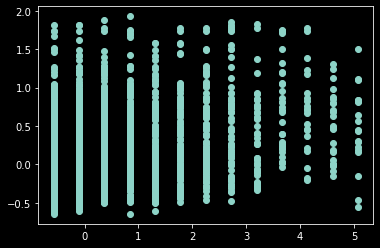

In [11]:
# Extract the predicted output values from the model, then create a scatter plot of the predicted output versus actual output (from the data provided). This plot is also used to evaluate the accuracy of the model. According to the plot, is your model good for predicting health scores? Use the reg.predict() method to extract the predicted values.
reg_predictions = res.predict(x.transpose())
plt.scatter(health_data["health"], reg_predictions)


,age,income,illness,reduced,health
age,1.000193,-0.271126,0.205023,0.094763,0.018619
income,-0.271126,1.000193,-0.148840,-0.047554,-0.085807
illness,0.205023,-0.148840,1.000193,0.218158,0.360179
reduced,0.094763,-0.047554,0.218158,1.000193,0.280262
health,0.018619,-0.085807,0.360179,0.280262,1.000193


<AxesSubplot:>

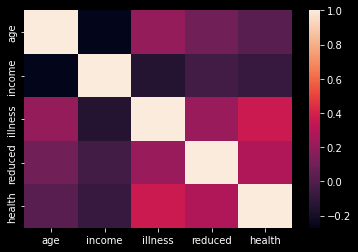

In [12]:
# Check for multi-collinearity by generating a covariance matrix for the input data . You can use the .cov() method of pandas (). Do you think there is multicollinearity among the input variables?
display(health_data.cov())
sns.heatmap(health_data.cov())


In [13]:
# Question 3:
#  Clean the data as you find necessary, standardize the data and split it into training and test data using an appropriate split ratio.
cigarette_data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/plm/Cigar.csv", index_col=0)
cigarette_data.drop(columns=["state", "year"], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    cigarette_data.drop(columns=["sales"]), cigarette_data["sales"], test_size=0.2, random_state=42
)

# Construct a linear regression model using ordinary least squares method by applying the LinearRegression() constructor in sklearn and find the training and test accuracy of this model using mean square error (mse).
lr_model = Pipeline([("scaler", StandardScaler()), ("reg", LinearRegression())])
lr_model.fit(X_train, y_train)
print("Training MSE:", metrics.mean_squared_error(y_train, lr_model.predict(X_train)))
print("Testing MSE:", metrics.mean_squared_error(y_test, lr_model.predict(X_test)))


Training MSE: 714.2766892826355
Testing MSE: 761.8831910334574


In [14]:
# Fit a lasso regression on the data and check the training and test accuracy of the model using mse. Use the default alpha or penalty constant.

# Fit a ridge regression on the data and check the training and test accuracy of the model. Use the default alpha or penalty constant.
for model in [Lasso(), Ridge()]:
    print(model.__class__.__name__)
    model = Pipeline([("scaler", StandardScaler()), ("reg", model)])
    model.fit(X_train, y_train)
    print("Training MSE:", metrics.mean_squared_error(y_train, model.predict(X_train)))
    print("Testing MSE:", metrics.mean_squared_error(y_test, model.predict(X_test)))
    print("-----------")


Lasso
Training MSE: 770.7736832371704
Testing MSE: 839.6807014786626
-----------
Ridge
Training MSE: 714.5831836887485
Testing MSE: 763.5358159469065
-----------


In [16]:
# Tune the alpha hyperparameters of the lasso and ridge regression using any tuning technique of your choice? What is the best alpha value for the lasso regression and what is the best alpha value for the ridge regression
alpha = np.logspace(-3, 0, 10)
lasso = Pipeline([("scaler", StandardScaler()), ("reg", Lasso(alpha=alpha))])
ridge = Pipeline([("scaler", StandardScaler()), ("reg", Ridge(alpha=alpha))])

for model in [lasso, ridge]:
    model = GridSearchCV(model, {"reg__alpha": alpha}, cv=15)
    print(model.estimator.steps[1][1].__class__.__name__)
    model.fit(X_train, y_train)
    print("Best alpha value:", model.best_params_["reg__alpha"])
    print("Training MSE:", metrics.mean_squared_error(y_train, model.predict(X_train)))
    print("Testing MSE:", metrics.mean_squared_error(y_test, model.predict(X_test)))
    print("-----------")


Lasso
Best alpha value: 0.046415888336127774
Training MSE: 715.0396992232547
Testing MSE: 764.08340054989
-----------
Ridge
Best alpha value: 1.0
Training MSE: 714.5831836887485
Testing MSE: 763.5358159469065
-----------
